# Case Study 2: Revenue Management


## Q1 – Calibrate Advance Sale Policies

Clara offers discounted advance rates — but only up to a certain number of bookings. Selling too many rooms in advance may lead to turning away spontaneous, higher-paying guests. Selling too few could leave occupancy short.

Using realized stays identify meaningful guest segments for each hotel. When do different types of guests book? What prices do they pay?

Estimate how many rooms Clara could allocate to advance sales for each property. Focus on lead times and potentially guest mix.


In [108]:
# imports
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [109]:
hotel_bookings = pd.read_csv("hotel_bookings.csv")

hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [110]:
hotel_bookings.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [111]:
# split up in two datasets for each hotel and filter out cancellations
city_hotel = hotel_bookings[
    (hotel_bookings["hotel"] == "City Hotel") & (hotel_bookings["is_canceled"] == 0)
]

resort_hotel = hotel_bookings[
    (hotel_bookings["hotel"] == "Resort Hotel") & (hotel_bookings["is_canceled"] == 0)
]

### Splitting up in segments


In [112]:
# business travelers (filter by company id)
def get_business_travelers(df):
    return df[~df["company"].isna()]


# family with at least one kid/baby
def get_families(df):
    return df[((df["children"] > 0) | (df["babies"] > 0)) & (df["adults"] > 0)]


# recurring guests
def get_loyal_guests(df):
    return df[(df["is_repeated_guest"] == 1)]


# group guests (bigger groups from e.g. events)
def get_group_guests(df):
    return df[df["customer_type"] == "Group"]

### Split up customer types in different segments


In [113]:
def create_lead_time_plot(hotel):

    business = get_business_travelers(hotel)
    families = get_families(hotel)
    loyal = get_loyal_guests(hotel)
    groups = get_group_guests(hotel)

    figure, axes = plt.subplots(2, 2, figsize=(12, 8))
    # Plot lead time distributions for each segment
    # Define bins and labels for lead time groups
    bins = [0, 7, 30, 90, 180, float("inf")]
    labels = ["<=7", "8-30", "31-90", "91-180", ">180"]

    # Group lead times for each segment
    business_bins = pd.cut(business["lead_time"], bins=bins, labels=labels, right=True)
    families_bins = pd.cut(families["lead_time"], bins=bins, labels=labels, right=True)
    loyal_bins = pd.cut(loyal["lead_time"], bins=bins, labels=labels, right=True)
    groups_bins = pd.cut(groups["lead_time"], bins=bins, labels=labels, right=True)

    # Plot bar charts for each segment
    axes[0, 0].bar(
        business_bins.value_counts(sort=False).index,
        business_bins.value_counts(sort=False).values,
        color="tab:blue",
        alpha=0.7,
    )
    axes[0, 1].bar(
        families_bins.value_counts(sort=False).index,
        families_bins.value_counts(sort=False).values,
        color="tab:orange",
        alpha=0.7,
    )
    axes[1, 0].bar(
        loyal_bins.value_counts(sort=False).index,
        loyal_bins.value_counts(sort=False).values,
        color="tab:green",
        alpha=0.7,
    )
    axes[1, 1].bar(
        groups_bins.value_counts(sort=False).index,
        groups_bins.value_counts(sort=False).values,
        color="tab:red",
        alpha=0.7,
    )
    axes[0, 0].set_title("Business Travelers")
    axes[0, 0].set_xlabel("Lead Time (days)")
    axes[0, 0].set_ylabel("Count")

    axes[0, 1].set_title("Families")
    axes[0, 1].set_xlabel("Lead Time (days)")
    axes[0, 1].set_ylabel("Count")

    axes[1, 0].set_title("Loyal Guests")
    axes[1, 0].set_xlabel("Lead Time (days)")
    axes[1, 0].set_ylabel("Count")

    axes[1, 1].set_title("Group Guests")
    axes[1, 1].set_xlabel("Lead Time (days)")
    axes[1, 1].set_ylabel("Count")

    plt.tight_layout()

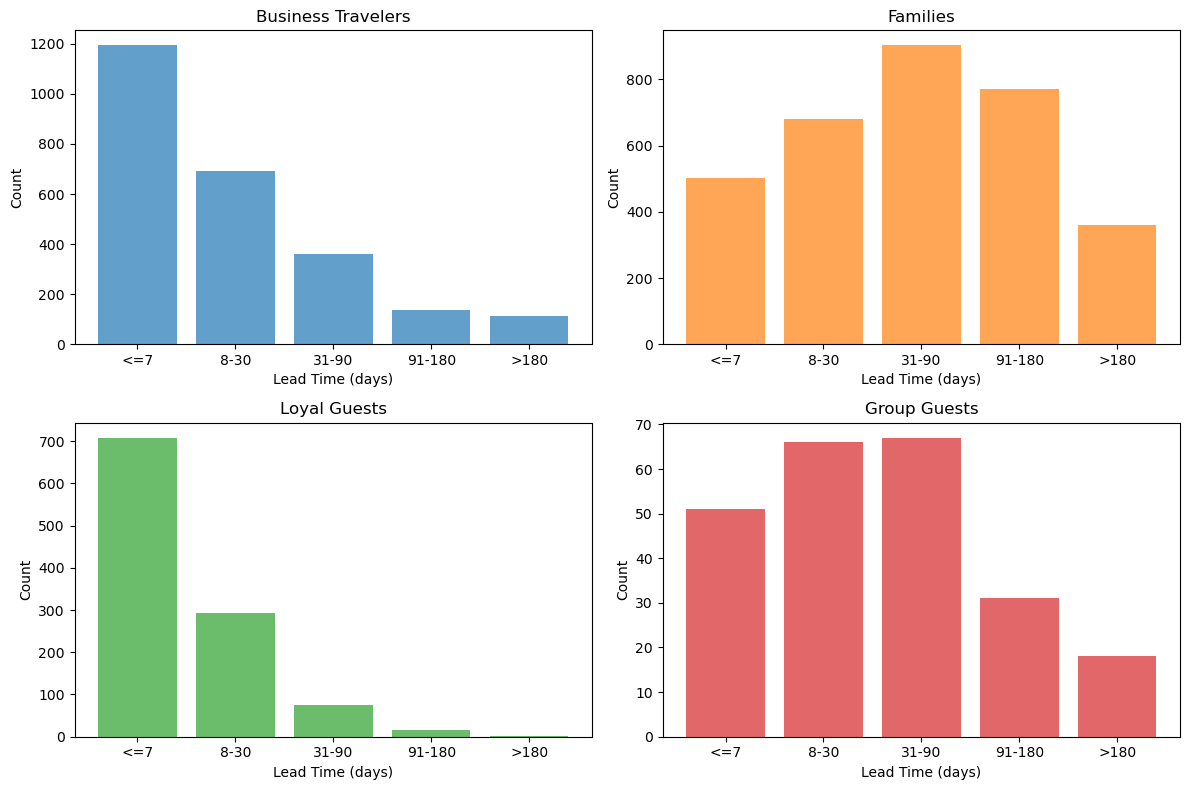

In [114]:
create_lead_time_plot(city_hotel)

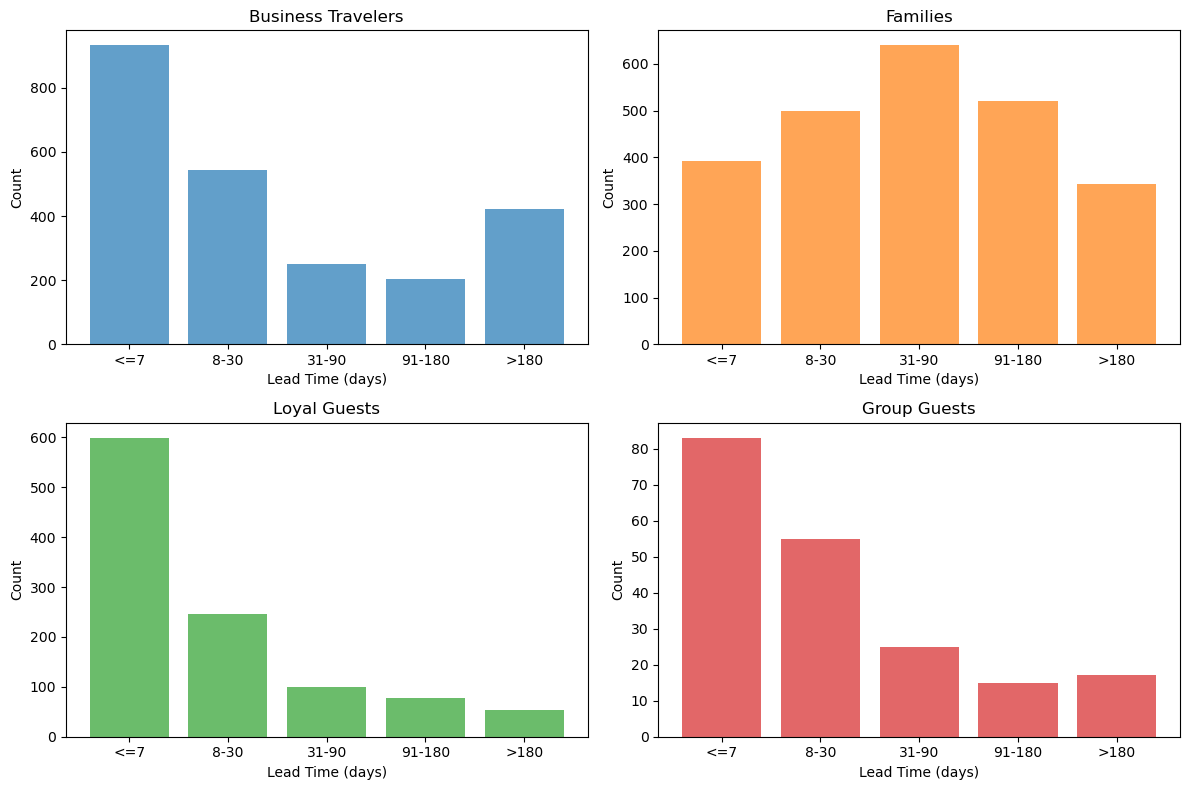

In [115]:
create_lead_time_plot(resort_hotel)

In [116]:
def create_adr_plot(hotel):
    figure, axes = plt.subplots(2, 2, figsize=(12, 8))

    business = get_business_travelers(hotel)
    families = get_families(hotel)
    loyal = get_loyal_guests(hotel)
    groups = get_group_guests(hotel)

    axes[0, 0].hist(business["adr"].dropna(), bins=30, color="tab:blue", alpha=0.7)
    axes[0, 1].hist(families["adr"].dropna(), bins=30, color="tab:orange", alpha=0.7)
    axes[1, 0].hist(loyal["adr"].dropna(), bins=30, color="tab:green", alpha=0.7)
    axes[1, 1].hist(groups["adr"].dropna(), bins=30, color="tab:red", alpha=0.7)

    axes[0, 0].set_title("Business Travelers")
    axes[0, 0].set_xlabel("ADR (Price per Night)")
    axes[0, 0].set_ylabel("Count")

    axes[0, 1].set_title("Families")
    axes[0, 1].set_xlabel("ADR (Price per Night)")
    axes[0, 1].set_ylabel("Count")

    axes[1, 0].set_title("Loyal Guests")
    axes[1, 0].set_xlabel("ADR (Price per Night)")

    # Plot mean as a vertical line for each segment
    axes[0, 0].axvline(
        business["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({business["adr"].mean():.2f})',
    )
    axes[0, 1].axvline(
        families["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({families["adr"].mean():.2f})',
    )
    axes[1, 0].axvline(
        loyal["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({loyal["adr"].mean():.2f})',
    )
    axes[1, 1].axvline(
        groups["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({groups["adr"].mean():.2f})',
    )
    for ax in axes.flat:
        ax.legend()
    axes[1, 0].set_ylabel("Count")

    axes[1, 1].set_title("Group Guests")
    axes[1, 1].set_xlabel("ADR (Price per Night)")
    axes[1, 1].set_ylabel("Count")

    plt.tight_layout()

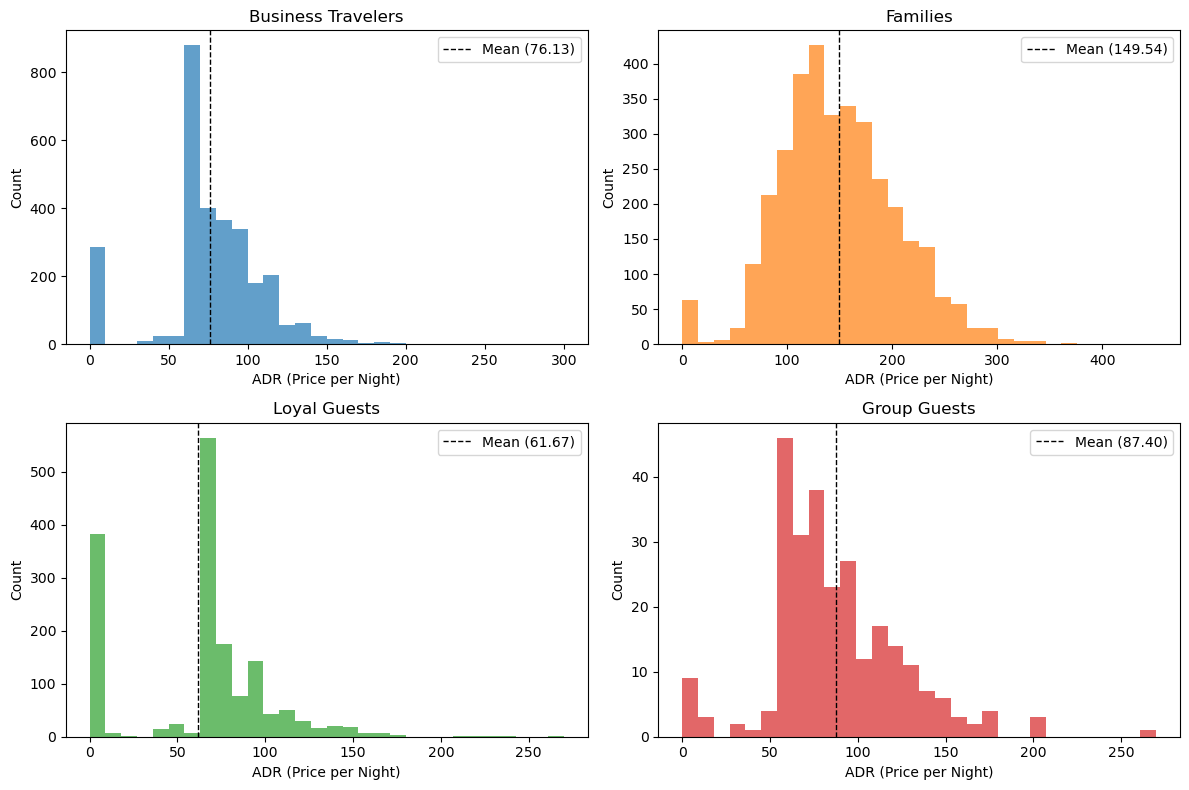

In [117]:
create_adr_plot(city_hotel)

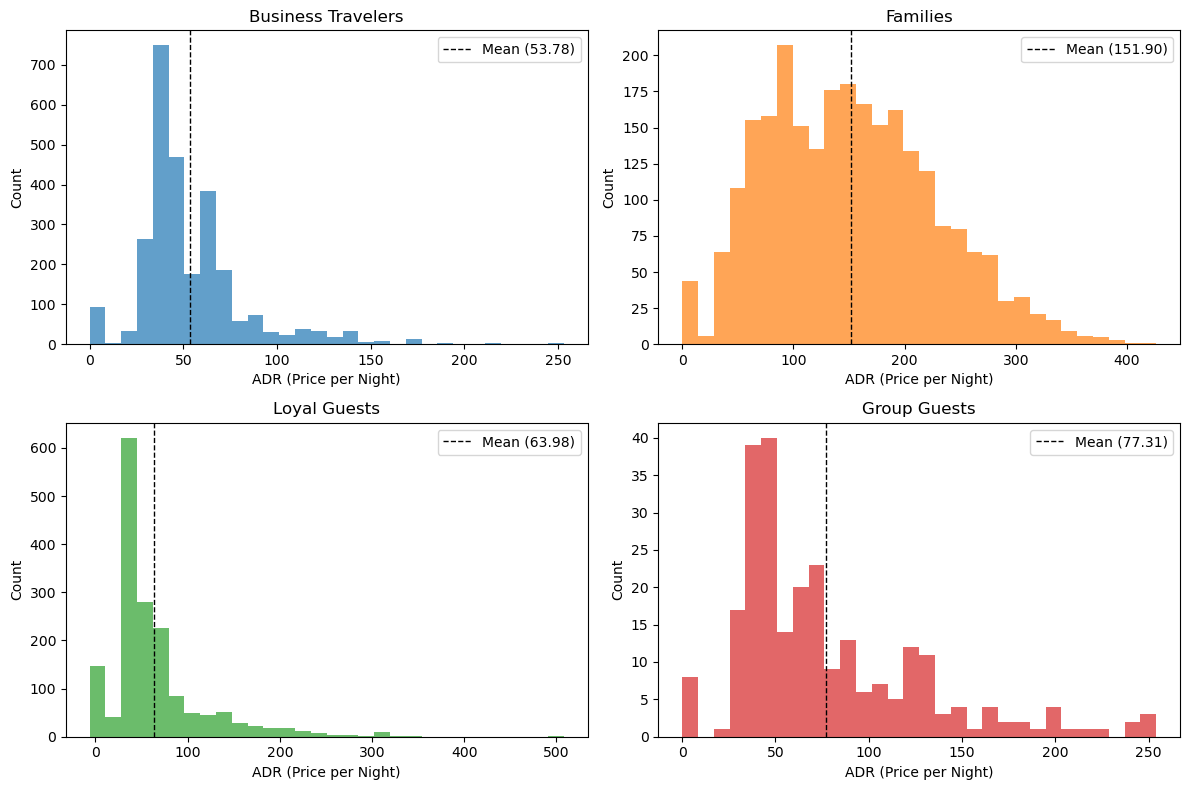

In [118]:
create_adr_plot(resort_hotel)

# Estimating the room number of the hotels


In [121]:
def show_bookings_per_day(hotel: DataFrame):
    # Berechne für jeden Tag die Anzahl der Gäste im Hotel
    df = hotel.copy()
    df["arrival"] = pd.to_datetime(
        df["arrival_date_year"].astype(str)
        + "-"
        + df["arrival_date_month"]
        + "-"
        + df["arrival_date_day_of_month"].astype(str),
        format="%Y-%B-%d",
    )
    df["nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

    # Erzeuge für jede Buchung alle Aufenthaltstage
    stay_dates = []
    for _, row in df.iterrows():
        for i in range(int(row["nights"])):
            stay_dates.append(row["arrival"] + pd.Timedelta(days=i))
    stay_dates = pd.Series(stay_dates)

    # Zähle Gäste pro Tag
    guests_per_day = stay_dates.value_counts().sort_index()

    plt.guests_per_day.plot()
    plt.title("Anzahl Gäste pro Tag im Hotel")
    plt.xlabel("Datum")
    plt.ylabel("Anzahl Gäste")
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

In [129]:
def guests_per_day(hotel: DataFrame):
    # Berechne für jeden Tag die Anzahl der Gäste im Hotel
    df = hotel.copy()
    df["arrival"] = pd.to_datetime(
        df["arrival_date_year"].astype(str)
        + "-"
        + df["arrival_date_month"]
        + "-"
        + df["arrival_date_day_of_month"].astype(str),
        format="%Y-%B-%d",
    )
    df["nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

    # Erzeuge für jede Buchung alle Aufenthaltstage
    stay_dates = []
    for _, row in df.iterrows():
        for i in range(int(row["nights"])):
            stay_dates.append(row["arrival"] + pd.Timedelta(days=i))
    stay_dates = pd.Series(stay_dates)

    # Zähle Gäste pro Tag
    guests_per_day = stay_dates.value_counts().sort_index()

    return guests_per_day

In [ ]:
max_guests_city = guests_per_day(city_hotel).max()
max_guests_resort = guests_per_day(resort_hotel).max()

print(f"Maximale Gäste an einem Tag im City Hotel: {max_guests_city}")
print(f"Maximale Gäste an einem Tag im Resort Hotel: {max_guests_resort}")
# exakte RaumanzahL!!!

Maximale Gäste im City Hotel: 226
Maximale Gäste im Resort Hotel: 187


## Estimating the high and low demand fare


## Q2 – Derive Overbooking Parameters

Clara wants to implement an overbooking policy to mitigate late cancellations and no-shows. But overbooking comes with risk: walk-aways hurt guest satisfaction and brand image.

Use historical data to estimate a robust overbooking buffer for each hotel. How many extra bookings can Clara accept without incurring frequent walk-aways?

Explain any trade-offs and assumptions you make.


## Q3 – Seasonally Update Your Rules

Demand patterns change throughout the year, and Clara would like to **adapt** her advance sale and overbooking thresholds to seasonality.

Using appropriate aggregates from past years, identify periods of stronger or weaker demand for each hotel. How would your advance booking limits and overbooking buffers from Q1 and Q2 change across these periods?

Provide updated rules for both city and resort hotels and justify your logic using observed patterns.


## Q4 – Operate on Live Booking Data

Imagine Clara gives you access to a daily stream of individual bookings coming in for the next season. For each booking, you see the date, stay period, channel, price.

Design a **monitoring system** that updates Clara’s advance sale ceilings and overbooking parameters as real bookings accumulate. What metrics would you track? How would you flag when adjustments are needed?

Use a small mock dataset or simulated example to demonstrate how this dynamic process could work. Highlight how **static rules** (from Q1 and Q2) evolve when applied in real time.


# TODO

- Mean für die Lead Time
- Über Segments nachdenken
- Raumanzahl x/0,85/1,75 (für Anzahl Räume als Estimate)
